## **Read in Raw NSL-KDD Dataset**

In [0]:
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('NSL_KDD_Train.csv', origin='https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv')
except:
    print('Error downloading')
    raise
    
print(path) 

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path, header=None)

print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)

# The CSV file has no column heads, so add them
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'label'
]

# display 5 rows
df[0:5]

14368768/14361833 [==============================] - 0s 0us/step
/root/.keras/datasets/NSL_KDD_Train.csv
Read 125973 rows.


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## **Analyzing the Dataset**

In [0]:
ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [0]:
# Analyze NSL-KDD

import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

analyze(df)


125973 rows
** duration:2981 (2%)
** protocol_type:[tcp:81.52%,udp:11.9%,icmp:6.58%]
** service:[http:32.02%,private:17.35%,domain_u:7.18%,smtp:5.81%,ftp_data:5.45%,eco_i:3.64%,other:3.46%,ecr_i:2.44%,telnet:1.87%,finger:1.4%,ftp:1.39%,auth:0.76%,Z39_50:0.68%,uucp:0.62%,courier:0.58%,bgp:0.56%,whois:0.55%,uucp_path:0.55%,iso_tsap:0.55%,time:0.52%,imap4:0.51%,nnsp:0.5%,vmnet:0.49%,urp_i:0.48%,domain:0.45%,ctf:0.45%,csnet_ns:0.43%,supdup:0.43%,discard:0.43%,http_443:0.42%,daytime:0.41%,gopher:0.41%,efs:0.39%,systat:0.38%,link:0.38%,exec:0.38%,hostnames:0.37%,name:0.36%,mtp:0.35%,echo:0.34%,klogin:0.34%,login:0.34%,ldap:0.33%,netbios_dgm:0.32%,sunrpc:0.3%,netbios_ssn:0.29%,netstat:0.29%,netbios_ns:0.28%,ssh:0.25%,kshell:0.24%,nntp:0.23%,pop_3:0.21%,sql_net:0.19%,IRC:0.15%,ntp_u:0.13%,rje:0.07%,remote_job:0.06%,pop_2:0.06%,X11:0.06%,printer:0.05%,shell:0.05%,urh_i:0.01%,red_i:0.01%,tim_i:0.01%,pm_dump:0.0%,tftp_u:0.0%,aol:0.0%,harvest:0.0%,http_8001:0.0%,http_2784:0.0%]
** flag:[SF:59.49%

## **Encode the feature vector**

In [0]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "%s-%s" % (name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [0]:
# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net


# Convert to numpy - Classification
x_columns = df.columns.drop('label')
x = df[x_columns].values
dummies = pd.get_dummies(df['label']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

## **The 23 output classes**

In [0]:
df.groupby('label')['label'].count()

label
back                 956
buffer_overflow       30
ftp_write              8
guess_passwd          53
imap                  11
ipsweep             3599
land                  18
loadmodule             9
multihop               7
neptune            41214
nmap                1493
normal             67343
perl                   3
phf                    4
pod                  201
portsweep           2931
rootkit               10
satan               3633
smurf               2646
spy                    2
teardrop             892
warezclient          890
warezmaster           20
Name: label, dtype: int64

## **Train the Neural Network**

In [0]:
import pandas as pd
import io
import requests
import numpy as np
import os
import timeit
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

#Custom Metrics
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Create a test/train split. 50% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=42)

num_of_features = x_train.shape[1] #120 features
nb_classes = y_train.shape[1] #23 detected actions

# Reshaping x_train and x_test for efficient modelling
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Model
model = Sequential()

model.add(LSTM(50, input_shape=(num_of_features,1), return_sequences=False))
model.add(Dense(nb_classes,activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', precision_m, recall_m, f1_m])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')

startTime = timeit.default_timer()
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=64)
elapsedTime = timeit.default_timer() - startTime

print("Time taken for the Network to train:",elapsedTime)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 62986 samples, validate on 62987 samples
Epoch 1/64
62986/62986 [==============================] - 261s 4ms/sample - loss: 1.2849 - acc: 0.5338 - precision_m: 0.4782 - recall_m: 0.4593 - f1_m: 0.4601 - val_loss: 1.2594 - val_acc: 0.5336 - val_precision_m: 0.5337 - val_recall_m: 0.5337 - val_f1_m: 0.5337
Epoch 2/64
62986/62986 [==============================] - 259s 4ms/sample - loss: 0.8574 - acc: 0.7276 - precision_m: 0.7301 - recall_m: 0.6937 - f1_m: 0.7062 - val_loss: 0.5885 - val_acc: 0.8342 - val_precision_m: 0.8674 - val_recall_m: 0.7915 - val_f1_m: 0.8271
Epoch 3/64
62986/62986 [==============================] - 262s 4ms/sample - loss: 0.5388 - acc: 0.8428 - precision_m: 0.8676 - recall_m: 0.8165 - f1_m: 0.8402 - val_loss: 0.4057 - val_acc: 0.8932 - val_precision_m: 0.9384 - val_recall_m: 0.8357 - 

## **Plotting & Evaluating Metrics**

Evaluating...
Plotting the metrics...


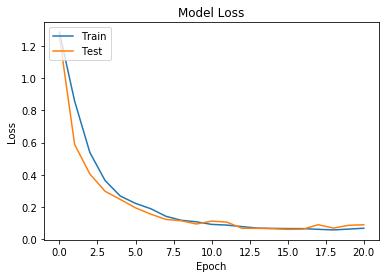

Loss: 9.05%


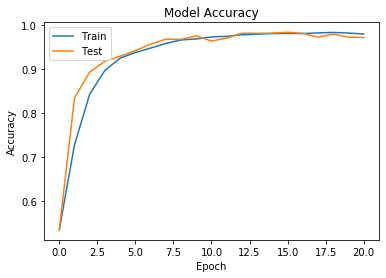

Accuracy: 97.18%


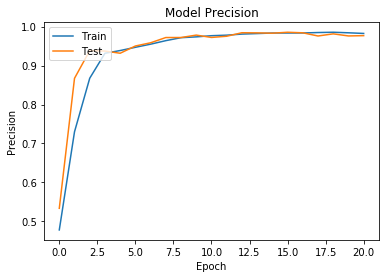

Precision: 97.69%


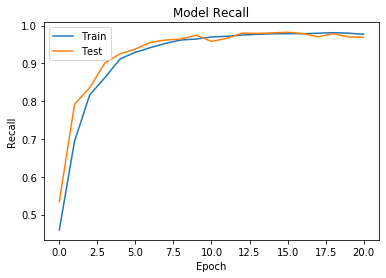

Recall: 96.91%


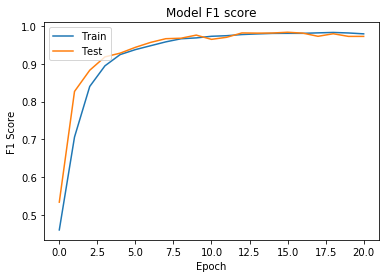

F1 Score: 97.30%

Final Score...
Validation/Final Score: 97.18%


In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#Evaluating
print("Evaluating...")
loss, accuracy, precision, recall, f1_score = model.evaluate(x_test, y_test, verbose=0, batch_size=1024)

print("Plotting the metrics...")
plt.rcParams["figure.figsize"] = [6,4]

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Loss: %.2f%%' % (loss*100))

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Accuracy: %.2f%%' % (accuracy*100))

# Plot training & validation precision values
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Precision: %.2f%%' % (precision*100))

# Plot training & validation recall values
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Recall: %.2f%%' % (recall*100))

# Plot training & validation f1 score values
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1 score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('F1 Score: %.2f%%' % (f1_score*100))


# Final Score
print('\nFinal Score...')
y_p = model.predict(x_test)
y_pred = np.argmax(y_p,axis=1) #Return a 1D binary vector indicating the ID of the mac number in the row
y_eval = np.argmax(y_test,axis=1) #Return a 1D binary vector indicating the ID of the mac number in the row
score = accuracy_score(y_eval, y_pred)
print('Validation/Final Score: %.2f%%' % (score*100))




## **Confusion Matrix**

Array combinations: ...
Confusion matrix, without normalization
[[33141   170   208     0    91]
 [  238  5548    58     0     3]
 [   76    11 22902     0     0]
 [   18     0     0     0     5]
 [  178     3     1     0   336]]


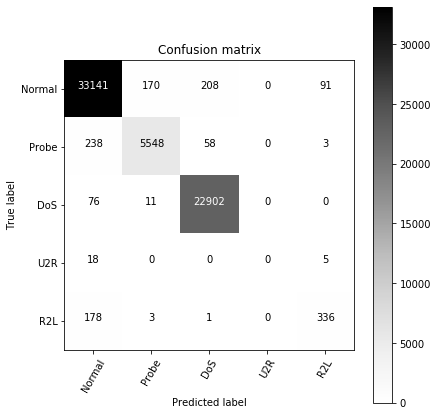

Normalized confusion matrix
[[9.86045820e-01 5.05801845e-03 6.18863434e-03 0.00000000e+00
  2.70752752e-03]
 [4.07046349e-02 9.48862665e-01 9.91961690e-03 0.00000000e+00
  5.13083633e-04]
 [3.30592892e-03 4.78489712e-04 9.96215581e-01 0.00000000e+00
  0.00000000e+00]
 [7.82608696e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.17391304e-01]
 [3.43629344e-01 5.79150579e-03 1.93050193e-03 0.00000000e+00
  6.48648649e-01]]


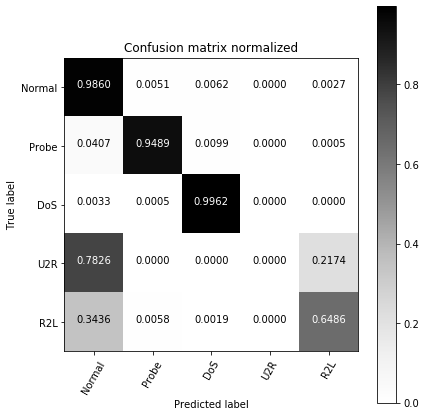

Each row adds 1 in total


In [0]:
# Measure accuracy
from sklearn.metrics import confusion_matrix
import itertools
import sys

# Confusion Matrix
def plot_confusion_matrix(cm, labels, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greys):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    plt.rcParams["figure.figsize"] = [6,6]
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=60)
        plt.yticks(tick_marks, labels)
    else:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{0:.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{0:.0f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Grouping in the 5 main categories in the KDD-99 dataset
# 0 Normal (no attack)
y_p0 = np.delete(y_p, [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22], axis=1)
y_p0s = np.sum(y_p0, axis=1)
y_p0r= y_p0s.reshape(y_p0s.shape[0], 1)
y_t0 = np.delete(y_test, [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22], axis=1)
y_t0s = np.sum(y_t0, axis=1)
y_t0r= y_t0s.reshape(y_t0s.shape[0], 1)

# 1 Probe
y_p1 = np.delete(y_p, [0,1,2,3,4,6,7,8,9,11,12,13,14,16,18,19,20,21,22], axis=1)
y_p1s = np.sum(y_p1, axis=1)
y_p1r= y_p1s.reshape(y_p1s.shape[0], 1)
y_t1 = np.delete(y_test, [0,1,2,3,4,6,7,8,9,11,12,13,14,16,18,19,20,21,22], axis=1)
y_t1s = np.sum(y_t1, axis=1)
y_t1r= y_t1s.reshape(y_t1s.shape[0], 1)

# 2 DoS
y_p2 = np.delete(y_p, [1,2,3,4,5,7,8,10,11,12,13,15,16,17,19,21,22], axis=1)
y_p2s = np.sum(y_p2, axis=1)
y_p2r= y_p2s.reshape(y_p2s.shape[0], 1)
y_t2 = np.delete(y_test, [1,2,3,4,5,7,8,10,11,12,13,15,16,17,19,21,22], axis=1)
y_t2s = np.sum(y_t2, axis=1)
y_t2r= y_t2s.reshape(y_t2s.shape[0], 1)

# 3 U2R
y_p3 = np.delete(y_p, [0,2,3,4,5,6,8,9,10,11,13,14,15,17,18,19,20,21,22], axis=1)
y_p3s = np.sum(y_p3, axis=1)
y_p3r= y_p2s.reshape(y_p3s.shape[0], 1)
y_t3 = np.delete(y_test, [0,2,3,4,5,6,8,9,10,11,13,14,15,17,18,19,20,21,22], axis=1)
y_t3s = np.sum(y_t3, axis=1)
y_t3r= y_t3s.reshape(y_t3s.shape[0], 1)

# 4 R2L
y_p4 = np.delete(y_p, [0,1,5,6,7,9,10,11,12,14,15,16,17,18,20], axis=1)
y_p4s = np.sum(y_p4, axis=1)
y_p4r= y_p4s.reshape(y_p4s.shape[0], 1)
y_t4 = np.delete(y_test, [0,1,5,6,7,9,10,11,12,14,15,16,17,18,20], axis=1)
y_t4s = np.sum(y_t4, axis=1)
y_t4r= y_t4s.reshape(y_t4s.shape[0], 1)

y_predT = np.concatenate((y_p0r, y_p1r, y_p2r, y_p3r, y_p4r), axis=1)
y_testT = np.concatenate((y_t0r, y_t1r, y_t2r, y_t3r, y_t4r), axis=1)
y_pred2 = np.argmax(y_predT,axis=1) #Return a 1D binary vector indicating the ID of the mac number in the row
y_eval2 = np.argmax(y_testT,axis=1) #Return a 1D binary vector indicating the ID of the mac number in the row


print("Array combinations: ...")

labels = ['Normal', 'Probe', 'DoS', 'U2R', 'R2L']
cm = confusion_matrix(y_eval2, y_pred2)
plot_confusion_matrix(cm, labels, classes=list(range(4)), normalize=False, title='Confusion matrix')
plot_confusion_matrix(cm, labels, classes=list(range(4)), normalize=True, title='Confusion matrix normalized')
print("Each row adds 1 in total")


## **Error parameters**

In [0]:
print("Printing the parameters of each class...")
print("\n")
# TP
TP = np.diag(cm)

# FP
FP = []
for i in range(cm.shape[0]):
    FP.append(sum(cm[:,i]) - cm[i,i])

# FN    
FN = []
for i in range(cm.shape[0]):
    FN.append(sum(cm[i,:]) - cm[i,i])    

# TN
TN = []
for i in range(cm.shape[0]):
    temp = np.delete(cm, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))   

# Creating the lists
FPR = []
TNR = []
FNR = []
TPR = []
ACC = []
PRE = []
REC = []
F1 = []
for i in range(cm.shape[0]):
    fpri = FP[i]/(TN[i]+FP[i])*100
    tnri = TN[i]/(TN[i]+FP[i])*100
    fnri = FN[i]/(FN[i]+TP[i])*100
    tpri = TP[i]/(TP[i]+FN[i])*100
    acci = (TP[i]+TN[i])/(TP[i]+FN[i]+TN[i]+FP[i])*100
    prei = TP[i]/(TP[i]+FP[i])*100
    reci = TP[i]/(TP[i]+FN[i])*100
    f1i = 2*(prei*reci)/(prei+reci)

    FPR.append(round(fpri,2))
    TNR.append(round(tnri,2))
    FNR.append(round(fnri,2))
    TPR.append(round(tpri,2))
    ACC.append(round(acci,2))
    PRE.append(round(prei,2))
    REC.append(round(reci,2))
    F1.append(round(f1i,2))

# Making a dataframe for printing a table
TPs=np.asarray(TP)
FPs=np.asarray(FP)
FNs=np.asarray(FN)
TNs=np.asarray(TN)
FPRs=np.asarray(FPR)
TNRs=np.asarray(TNR)
FNRs=np.asarray(FNR)
TPRs=np.asarray(TPR)
ACCs=np.asarray(ACC)
PREs=np.asarray(PRE)
RECs=np.asarray(REC)
F1s=np.asarray(F1)

TPt= TPs.reshape(TPs.shape[0], 1)
FPt= FPs.reshape(FPs.shape[0], 1)
FNt= FNs.reshape(FNs.shape[0], 1)
TNt= TNs.reshape(TNs.shape[0], 1)
FPRt= FPRs.reshape(FPRs.shape[0], 1)
TNRt= TNRs.reshape(TNRs.shape[0], 1)
FNRt= FNRs.reshape(FNRs.shape[0], 1)
TPRt= TPRs.reshape(TPRs.shape[0], 1)
ACCt= ACCs.reshape(ACCs.shape[0], 1)
PREt= PREs.reshape(PREs.shape[0], 1)
RECt= RECs.reshape(RECs.shape[0], 1)
F1t= F1s.reshape(F1s.shape[0], 1)

param = np.concatenate((TPt, FPt, FNt, TNt, FPRt, TNRt, FNRt, TPRt, ACCt, PREt, RECt, F1t), axis=1)

dfParam= pd.DataFrame(param, columns = ['TP', 'FP', 'FN', 'TN', 'FPR/FAR(%)', 'TNR(%)', 'FNR(%)', 'TPR/DR(%)', 'Accuracy(%)', 'Precision(%)', 'Recall(%)', 'F1 Score(%)'], index=labels)

dfParam[0:len(labels)]

Printing the parameters of each class...




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in long_scalars


,TP,FP,FN,TN,FPR/FAR(%),TNR(%),FNR(%),TPR/DR(%),Accuracy(%),Precision(%),Recall(%),F1 Score(%)
Normal,33141.0,510.0,469.0,28867.0,1.74,98.26,1.40,98.60,98.45,98.48,98.60,98.54
Probe,5548.0,184.0,299.0,56956.0,0.32,99.68,5.11,94.89,99.23,96.79,94.89,95.83
DoS,22902.0,267.0,87.0,39731.0,0.67,99.33,0.38,99.62,99.44,98.85,99.62,99.23
U2R,0.0,0.0,23.0,62964.0,0.00,100.00,100.00,0.00,99.96,NaN,0.00,NaN
R2L,336.0,99.0,182.0,62370.0,0.16,99.84,35.14,64.86,99.55,77.24,64.86,70.51


## **ROC**

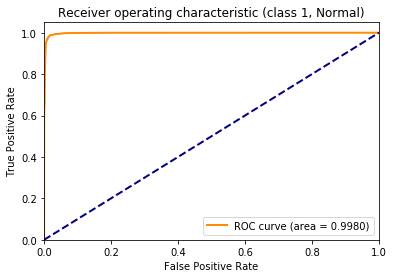

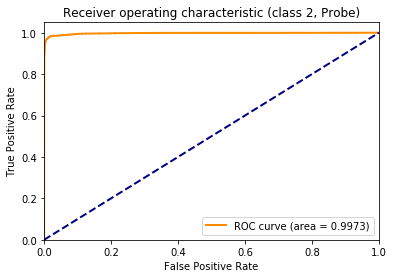

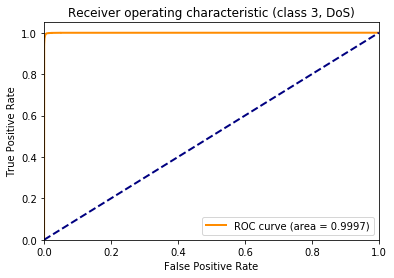

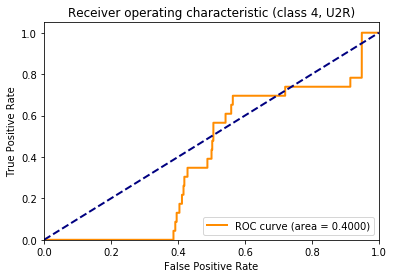

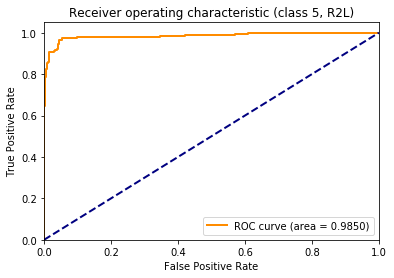

In [0]:
# ROC
def plot_roc_curve(Y_test, Y_pred, classes, labels):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y_test[:, i], Y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])   
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(Y_test.ravel(), Y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])   
    #plt.figure()
    lw = 2
    plt.rcParams["figure.figsize"] = [6,4]
    for i in range(classes):
      plt.plot(fpr[i], tpr[i], color='darkorange',
              lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver operating characteristic (class '+ str(i+1) +', '+ labels[i] +')')
      plt.legend(loc="lower right")
      plt.show()

plot_roc_curve(y_testT, y_predT, len(labels), labels)
